# Census Tract Crosswalk - Harmonizing 2010 & 2021 Population Data

## Problem
Census tract boundaries changed between 2010 and 2020:
- 2010: 782 tracts in Harris County
- 2021: 1,093 tracts (uses 2020 boundaries)
- Only 481 tracts remained unchanged

This means we can't directly compare 2010 population to 2021 population for ~56% of tracts!

## Solution: Use Census Crosswalk File
The Census Bureau provides "relationship files" that map how old tracts split/merged into new tracts.

**This notebook:**
1. Loads the tract crosswalk file (2010 → 2020 boundaries)
2. Uses **area-weighted interpolation** to allocate 2010 & 2015 population to 2020 boundaries
3. Merges with 2021 data (already on 2020 boundaries)
4. Outputs harmonized dataset with ~1,093 tracts on consistent boundaries

## Expected Result
- **~1,093 tracts** (vs 481 with "common tracts only")
- **~100% population coverage** (vs 45%)
- All data on 2020 census boundaries
- Ready for ML modeling!

In [3]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import requests
import os
from pathlib import Path


In [4]:
# Cell 3: Load and Explore Crosswalk
def load_crosswalk(filepath, county_fips='48201'):
    """Load crosswalk and filter to Harris County"""
    
    print("\n📂 Loading crosswalk file...")
    
    # Load with pipe delimiter
    crosswalk = pd.read_csv(filepath, sep='|', dtype=str)
    
    print(f"✅ Loaded crosswalk with {len(crosswalk)} relationships")
    print(f"\nColumns: {list(crosswalk.columns)}")
    
    # Filter to Harris County (FIPS 48201)
    harris = crosswalk[
        (crosswalk['GEOID_TRACT_20'].str.startswith(county_fips)) |
        (crosswalk['GEOID_TRACT_10'].str.startswith(county_fips))
    ].copy()
    
    print(f"\n✅ Filtered to Harris County: {len(harris)} relationships")
    
    # Convert area fields to numeric
    harris['AREALAND_TRACT_10'] = pd.to_numeric(harris['AREALAND_TRACT_10'])
    harris['AREALAND_PART'] = pd.to_numeric(harris['AREALAND_PART'])
    harris['AREALAND_TRACT_20'] = pd.to_numeric(harris['AREALAND_TRACT_20'])
    
    return harris

crosswalk_file = '../data/small/census/tab20_tract20_tract10_st48.txt'

# Load crosswalk
crosswalk = load_crosswalk(crosswalk_file)

# Preview
print("\nFirst few relationships:")
print(crosswalk[['GEOID_TRACT_10', 'GEOID_TRACT_20', 'AREALAND_PART', 'AREALAND_TRACT_10']].head().to_string())


📂 Loading crosswalk file...
✅ Loaded crosswalk with 9135 relationships

Columns: ['OID_TRACT_20', 'GEOID_TRACT_20', 'NAMELSAD_TRACT_20', 'AREALAND_TRACT_20', 'AREAWATER_TRACT_20', 'MTFCC_TRACT_20', 'FUNCSTAT_TRACT_20', 'OID_TRACT_10', 'GEOID_TRACT_10', 'NAMELSAD_TRACT_10', 'AREALAND_TRACT_10', 'AREAWATER_TRACT_10', 'MTFCC_TRACT_10', 'FUNCSTAT_TRACT_10', 'AREALAND_PART', 'AREAWATER_PART']

✅ Filtered to Harris County: 1381 relationships

First few relationships:
     GEOID_TRACT_10 GEOID_TRACT_20  AREALAND_PART  AREALAND_TRACT_10
3419    48201455102    48157673005           2366            1613219
3426    48201455300    48157673103          97015            5461856
3427    48201542700    48157673103            840            4800052
3435    48201455300    48157673107          34114            5461856
3437    48201542700    48157673108          67559            4800052


In [5]:
# Cell 4: Analyze Tract Changes
def analyze_tract_changes(crosswalk):
    """Analyze how tracts changed between 2010 and 2020"""
    
    tracts_2010 = crosswalk['GEOID_TRACT_10'].unique()
    tracts_2020 = crosswalk['GEOID_TRACT_20'].unique()
    
    print("="*60)
    print("TRACT CHANGES: 2010 → 2020")
    print("="*60)
    print(f"2010 tracts: {len(tracts_2010)}")
    print(f"2020 tracts: {len(tracts_2020)}")
    print(f"Net change: {len(tracts_2020) - len(tracts_2010):+d}")
    
    # Find splits (one 2010 tract → multiple 2020 tracts)
    splits = crosswalk.groupby('GEOID_TRACT_10').size()
    split_tracts = splits[splits > 1]
    
    print(f"\n🔀 Split tracts: {len(split_tracts)}")
    if len(split_tracts) > 0:
        print("   Examples:")
        for tract, count in list(split_tracts.head(3).items()):
            print(f"   - {tract} → {count} tracts")
    
    # Find merges (multiple 2010 tracts → one 2020 tract)
    merges = crosswalk.groupby('GEOID_TRACT_20').size()
    merge_tracts = merges[merges > 1]
    
    print(f"\n🔗 Merged tracts: {len(merge_tracts)}")
    if len(merge_tracts) > 0:
        print("   Examples:")
        for tract, count in list(merge_tracts.head(3).items()):
            print(f"   - {count} tracts → {tract}")
    
    print("="*60)

# Run analysis
analyze_tract_changes(crosswalk)

TRACT CHANGES: 2010 → 2020
2010 tracts: 792
2020 tracts: 1122
Net change: +330

🔀 Split tracts: 394
   Examples:
   - 48157671900 → 2 tracts
   - 48201100000 → 2 tracts
   - 48201210400 → 2 tracts

🔗 Merged tracts: 203
   Examples:
   - 2 tracts → 48157673103
   - 2 tracts → 48201210500
   - 2 tracts → 48201211502


In [6]:
# Cell 5: Load Your Population Data
print("📂 Loading population data...")

# Load 2010 census data
pop_2010_raw = pd.read_csv('../data/processed/census/cleaned_ACSDT5YSPT2010.B01003-Data.csv')
pop_2010_raw = pop_2010_raw[pop_2010_raw['GEOID'] > 48201000000].copy()
pop_2010 = pop_2010_raw[['GEOID', 'Estimate!!Total']].copy()
pop_2010.columns = ['GEOID', 'population']
pop_2010['population'] = pd.to_numeric(pop_2010['population'], errors='coerce')
pop_2010 = pop_2010.dropna(subset=['population'])
print(f"✅ Loaded 2010: {len(pop_2010)} tracts")

# Load 2015 census data
pop_2015_raw = pd.read_csv('../data/processed/census/cleaned_ACSDT5YSPT2015.B01003-Data.csv')
pop_2015_raw = pop_2015_raw[pop_2015_raw['GEOID'] > 48201000000].copy()
pop_2015 = pop_2015_raw[['GEOID', 'Estimate!!Total']].copy()
pop_2015.columns = ['GEOID', 'population']
pop_2015['population'] = pd.to_numeric(pop_2015['population'], errors='coerce')
pop_2015 = pop_2015.dropna(subset=['population'])
print(f"✅ Loaded 2015: {len(pop_2015)} tracts")

# Load 2021 census data (already on 2020 boundaries)
pop_2021_raw = pd.read_csv('../data/processed/census/cleaned_ACSDT5YSPT2021.B01003-Data.csv')
pop_2021_raw = pop_2021_raw[pop_2021_raw['GEOID'] > 48201000000].copy()
pop_2021 = pop_2021_raw[['GEOID', 'Estimate!!Total']].copy()
pop_2021.columns = ['GEOID', 'population']
pop_2021['population'] = pd.to_numeric(pop_2021['population'], errors='coerce')
pop_2021 = pop_2021.dropna(subset=['population'])
print(f"✅ Loaded 2021: {len(pop_2021)} tracts")

print(f"Total 2021 population: {pop_2021['population'].sum():,.0f}")

# Show structureprint(f"Total 2015 population: {pop_2015['population'].sum():,.0f}")

print("\n2010 data structure:")
print(f"\nTotal 2010 population: {pop_2010['population'].sum():,.0f}")
print(pop_2010.head())

📂 Loading population data...
✅ Loaded 2010: 782 tracts
✅ Loaded 2015: 785 tracts
✅ Loaded 2021: 1093 tracts
Total 2021 population: 4,662,148

2010 data structure:

Total 2010 population: 3,949,533
         GEOID  population
1  48201212300        5028
2  48201223100        2366
3  48201252100        1551
4  48201412600        3715
5  48201412700        3331


In [7]:
# Cell 6: Allocate Population to 2020 Boundaries
def allocate_to_2020_boundaries(pop_df, crosswalk, year_label):
    """
    Allocate population from 2010 boundaries to 2020 boundaries
    using area-weighted interpolation
    """
    
    print(f"\n🔄 Allocating {year_label} population to 2020 boundaries...")
    
    # Ensure GEOID is string
    pop_df = pop_df.copy()
    pop_df['GEOID'] = pop_df['GEOID'].astype(str)
    
    # Merge population with crosswalk
    merged = crosswalk.merge(
        pop_df[['GEOID', 'population']],
        left_on='GEOID_TRACT_10',
        right_on='GEOID',
        how='left'
    )
    
    # Calculate area weight for each piece
    merged['area_weight'] = merged['AREALAND_PART'] / merged['AREALAND_TRACT_10']
    
    # Allocate population proportionally
    merged['pop_allocated'] = merged['population'] * merged['area_weight']
    
    # Aggregate to 2020 tracts
    result = merged.groupby('GEOID_TRACT_20').agg({
        'pop_allocated': 'sum'
    }).reset_index()
    
    result.columns = ['GEOID', f'population_{year_label}']
    
    print(f"   ✅ Result: {len(result)} 2020 tracts")
    print(f"   Total population: {result[f'population_{year_label}'].sum():,.0f}")
    
    return result

# Allocate each year
pop_2010_adj = allocate_to_2020_boundaries(pop_2010, crosswalk, '2010')
pop_2015_adj = allocate_to_2020_boundaries(pop_2015, crosswalk, '2015')


🔄 Allocating 2010 population to 2020 boundaries...
   ✅ Result: 1122 2020 tracts
   Total population: 3,949,533

🔄 Allocating 2015 population to 2020 boundaries...
   ✅ Result: 1122 2020 tracts
   Total population: 4,356,354


In [8]:
# Cell 7: Prepare 2021 Data (Already on 2020 Boundaries)
print("\n✅ 2021 data already on 2020 boundaries")

pop_2021_clean = pop_2021[['GEOID', 'population']].copy()
pop_2021_clean['GEOID'] = pop_2021_clean['GEOID'].astype(str)
pop_2021_clean.columns = ['GEOID', 'population_2021']

print(f"   Tracts: {len(pop_2021_clean)}")
print(f"   Total population: {pop_2021_clean['population_2021'].sum():,.0f}")


✅ 2021 data already on 2020 boundaries
   Tracts: 1093
   Total population: 4,662,148


In [9]:
# Cell 8: Merge All Years
print("\n🔗 Merging all years on 2020 boundaries...")

# Start with 2021 (most recent)
result = pop_2021_clean.copy()
print(f"✅ Started with 2021: {len(result)} tracts")

# Add 2015
result = result.merge(pop_2015_adj, on='GEOID', how='outer')
print(f"✅ Added 2015: {len(result)} tracts")

# Add 2010
result = result.merge(pop_2010_adj, on='GEOID', how='outer')
print(f"✅ Added 2010: {len(result)} tracts")

# Show result
print(f"\n📊 Final dataset: {len(result)} tracts")
print(f"   Complete data (no missing): {result.dropna().shape[0]} tracts")
print("\nFirst few rows:")
print(result.head(10).to_string())


🔗 Merging all years on 2020 boundaries...
✅ Started with 2021: 1093 tracts
✅ Added 2015: 1122 tracts
✅ Added 2010: 1122 tracts

📊 Final dataset: 1122 tracts
   Complete data (no missing): 1093 tracts

First few rows:
         GEOID  population_2021  population_2015  population_2010
0  48157673005              NaN         5.340010         4.949886
1  48157673103              NaN        77.418855        36.742103
2  48157673107              NaN        26.932158        12.647871
3  48157673108              NaN        66.587118        62.209905
4  48201100001           4999.0      2925.637699      2581.878620
5  48201210400           4411.0      4818.734426      4919.603271
6  48201210500           5013.0      6067.265574      5015.396729
7  48201210600           5645.0      5391.000000      5667.000000
8  48201210700           2537.0      2176.000000      2008.000000
9  48201210800           2223.0      2563.000000      2276.000000


In [10]:
# Cell 9: Calculate Growth Rates
if result is not None:
    print("\n📈 Calculating growth rates...")
    
    # Growth 2010 → 2021
    if 'population_2010' in result.columns and 'population_2021' in result.columns:
        result['growth_2010_2021_abs'] = result['population_2021'] - result['population_2010']
        result['growth_2010_2021_pct'] = (result['growth_2010_2021_abs'] / result['population_2010']) * 100
        
        # Handle division by zero
        result['growth_2010_2021_pct'] = result['growth_2010_2021_pct'].replace([np.inf, -np.inf], np.nan)
        
        print(f"✅ Calculated 2010→2021 growth")
        print(f"   Mean growth: {result['growth_2010_2021_pct'].mean():.2f}%")
        print(f"   Median growth: {result['growth_2010_2021_pct'].median():.2f}%")
    
    # Growth 2010 → 2015
    if 'population_2010' in result.columns and 'population_2015' in result.columns:
        result['growth_2010_2015_pct'] = ((result['population_2015'] - result['population_2010']) / 
                                          result['population_2010']) * 100
        result['growth_2010_2015_pct'] = result['growth_2010_2015_pct'].replace([np.inf, -np.inf], np.nan)
        print(f"✅ Calculated 2010→2015 growth")
    
    # Growth 2015 → 2021
    if 'population_2015' in result.columns and 'population_2021' in result.columns:
        result['growth_2015_2021_pct'] = ((result['population_2021'] - result['population_2015']) / 
                                          result['population_2015']) * 100
        result['growth_2015_2021_pct'] = result['growth_2015_2021_pct'].replace([np.inf, -np.inf], np.nan)
        print(f"✅ Calculated 2015→2021 growth")
    
    # Show summary stats
    print("\n📊 Growth Rate Summary:")
    print(result[['growth_2010_2021_pct', 'growth_2010_2015_pct', 'growth_2015_2021_pct']].describe())


📈 Calculating growth rates...
✅ Calculated 2010→2021 growth
   Mean growth: 34.54%
   Median growth: 10.88%
✅ Calculated 2010→2015 growth
✅ Calculated 2015→2021 growth

📊 Growth Rate Summary:
       growth_2010_2021_pct  growth_2010_2015_pct  growth_2015_2021_pct
count           1093.000000           1118.000000           1093.000000
mean              34.537291             11.819470             19.165685
std               89.498637             20.807942             68.709450
min              -73.891261            -34.005226            -72.226835
25%               -5.675442             -0.678369             -9.299122
50%               10.884216              7.739854              4.018011
75%               38.902919             20.498870             22.868699
max              860.899595            174.772036            814.510984


C:\Users\arish\AppData\Local\Temp\ipykernel_6036\163581113.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(growth_data, labels=labels)


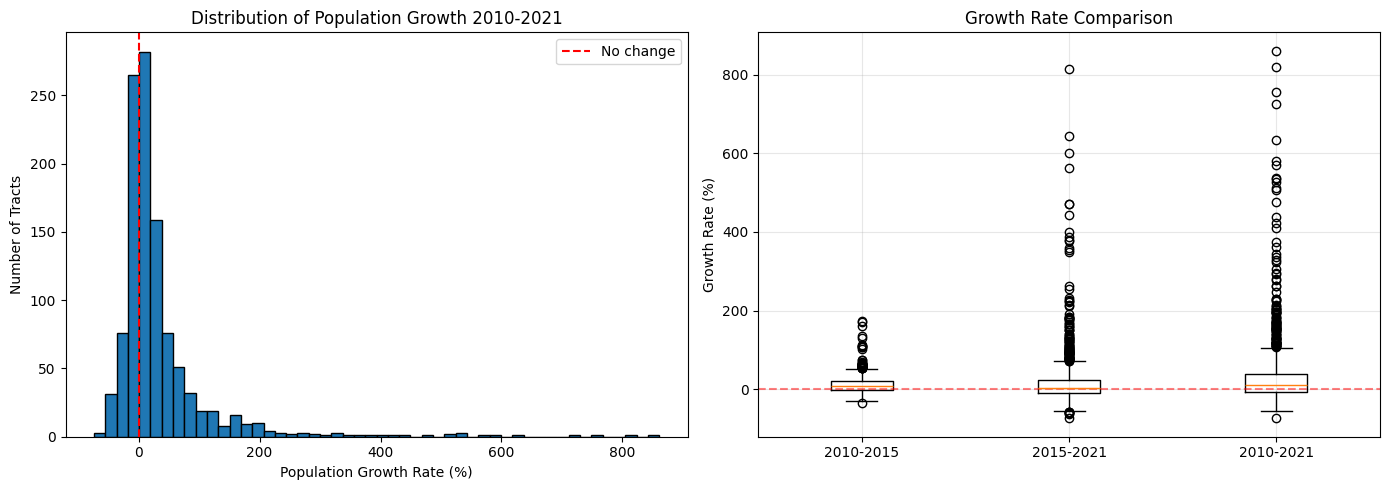

In [11]:
# Cell 10: Visualize Results
import matplotlib.pyplot as plt
import seaborn as sns

if result is not None and 'growth_2010_2021_pct' in result.columns:
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution of growth rates
    axes[0].hist(result['growth_2010_2021_pct'].dropna(), bins=50, edgecolor='black')
    axes[0].set_xlabel('Population Growth Rate (%)')
    axes[0].set_ylabel('Number of Tracts')
    axes[0].set_title('Distribution of Population Growth 2010-2021')
    axes[0].axvline(0, color='red', linestyle='--', label='No change')
    axes[0].legend()
    
    # Box plot
    growth_data = []
    labels = []
    if 'growth_2010_2015_pct' in result.columns:
        growth_data.append(result['growth_2010_2015_pct'].dropna())
        labels.append('2010-2015')
    if 'growth_2015_2021_pct' in result.columns:
        growth_data.append(result['growth_2015_2021_pct'].dropna())
        labels.append('2015-2021')
    if 'growth_2010_2021_pct' in result.columns:
        growth_data.append(result['growth_2010_2021_pct'].dropna())
        labels.append('2010-2021')
    
    if growth_data:
        axes[1].boxplot(growth_data, labels=labels)
        axes[1].set_ylabel('Growth Rate (%)')
        axes[1].set_title('Growth Rate Comparison')
        axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [12]:
# Cell 11: Save Harmonized Dataset
if result is not None:
    
    output_file = '../data/processed/population_harmonized.csv'
    result.to_csv(output_file, index=False)
    
    print(f"\n✅ Saved harmonized data: {output_file}")
    print(f"   Total tracts: {len(result)}")
    print(f"   Complete cases (no missing): {result.dropna().shape[0]}")
    
    # Also save a version with only complete cases
    result_complete = result.dropna()
    complete_file = '../data/processed/population_harmonized_complete.csv'
    result_complete.to_csv(complete_file, index=False)
    
    print(f"\n✅ Saved complete-cases only: {complete_file}")
    print(f"   Tracts: {len(result_complete)}")
    
    print("\n" + "="*60)
    print("HARMONIZATION COMPLETE ✅")
    print("="*60)
    print("\nNext steps:")
    print("1. Use 'population_harmonized_complete.csv' for ML model")
    print("2. Join with flood data using GEOID")
    print("3. All tracts now on consistent 2020 boundaries")
else:
    print("❌ No data to save")


✅ Saved harmonized data: ../data/processed/population_harmonized.csv
   Total tracts: 1122
   Complete cases (no missing): 1093

✅ Saved complete-cases only: ../data/processed/population_harmonized_complete.csv
   Tracts: 1093

HARMONIZATION COMPLETE ✅

Next steps:
1. Use 'population_harmonized_complete.csv' for ML model
2. Join with flood data using GEOID
3. All tracts now on consistent 2020 boundaries


In [13]:
# Cell 12: Quality Check
if result is not None:
    print("\n🔍 Data Quality Check:")
    print("="*60)
    
    # Check for missing values
    print("\nMissing values by column:")
    missing = result.isnull().sum()
    for col, count in missing[missing > 0].items():
        pct = (count / len(result)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
    
    # Check for outliers
    if 'growth_2010_2021_pct' in result.columns:
        growth = result['growth_2010_2021_pct'].dropna()
        
        print(f"\nGrowth rate outliers:")
        print(f"  Top 5 growth tracts:")
        top5 = result.nlargest(5, 'growth_2010_2021_pct')[['GEOID', 'growth_2010_2021_pct', 'population_2010', 'population_2021']]
        print(top5.to_string())
        
        print(f"\n  Bottom 5 growth tracts:")
        bottom5 = result.nsmallest(5, 'growth_2010_2021_pct')[['GEOID', 'growth_2010_2021_pct', 'population_2010', 'population_2021']]
        print(bottom5.to_string())
    
    print("="*60)


🔍 Data Quality Check:

Missing values by column:
  population_2021: 29 (2.6%)
  growth_2010_2021_abs: 29 (2.6%)
  growth_2010_2021_pct: 29 (2.6%)
  growth_2010_2015_pct: 4 (0.4%)
  growth_2015_2021_pct: 29 (2.6%)

Growth rate outliers:
  Top 5 growth tracts:
           GEOID  growth_2010_2021_pct  population_2010  population_2021
964  48201543004            860.899595      1294.620173          12440.0
962  48201542901            819.418945      1006.831549           9257.0
453  48201343602            755.363507       357.158094           3055.0
219  48201253101            724.704792       687.882507           5673.0
973  48201543201            633.425473       716.909924           5258.0

  Bottom 5 growth tracts:
           GEOID  growth_2010_2021_pct  population_2010  population_2021
429  48201341304            -73.891261      4829.800458           1261.0
294  48201314302            -56.305092      3242.940791           1417.0
642  48201432706            -56.190562      3585.985305 

## 13. Merge with Geographic/Environmental Features

Now merge the harmonized population data with the Harris County shapefile that contains:
- Elevation data (DEM_mean, DEM_min, DEM_max, DEM_std)
- Flow accumulation (FloAc_mean, FlowAc_max)
- Hazard zones (Haz_major, Haz_max)
- Geographic boundaries and area

This creates the final ML-ready dataset!

In [14]:
# Cell 13: Merge with Harris Census Geographic Data
print("\n" + "="*70)
print("MERGING WITH GEOGRAPHIC/ENVIRONMENTAL FEATURES")
print("="*70)

# Load the Harris County census tract shapefile with geographic features
harris_geo = pd.read_csv('../data/processed/census/Harris_Census_with_POP.csv')
print(f"\n📂 Loaded Harris County geographic data: {len(harris_geo)} tracts")
print(f"   Columns: {len(harris_geo.columns)}")

# Rename old population columns to preserve them
# These have data for the 482 tracts that matched directly
harris_geo.rename(columns={
    '2010_POP': 'POP_2010_original',
    '2015_POP': 'POP_2015_original', 
    '2021_POP': 'POP_2021_original'
}, inplace=True, errors='ignore')
print(f"\n✅ Renamed original population columns to preserve them")

# Ensure GEOID is string for merging
harris_geo['GEOID'] = harris_geo['GEOID'].astype(str)

# Merge with harmonized population data
harris_complete = harris_geo.merge(
    result_complete,
    on='GEOID',
    how='left'
)

print(f"\n✅ Merged geographic data with harmonized population")
print(f"   Total tracts: {len(harris_complete)}")
print(f"   Tracts with complete population data: {harris_complete['population_2010'].notna().sum()}")
print(f"   Tracts missing population: {harris_complete['population_2010'].isna().sum()}")

# Calculate additional features for ML
print(f"\n📊 Calculating additional features...")

# Area in square kilometers
harris_complete['area_sq_km'] = harris_complete['ALAND'] / 1_000_000

# Population density for each year
harris_complete['pop_density_2010'] = harris_complete['population_2010'] / harris_complete['area_sq_km']
harris_complete['pop_density_2015'] = harris_complete['population_2015'] / harris_complete['area_sq_km']
harris_complete['pop_density_2021'] = harris_complete['population_2021'] / harris_complete['area_sq_km']

# Replace inf values with NaN
harris_complete['pop_density_2010'] = harris_complete['pop_density_2010'].replace([np.inf, -np.inf], np.nan)
harris_complete['pop_density_2015'] = harris_complete['pop_density_2015'].replace([np.inf, -np.inf], np.nan)
harris_complete['pop_density_2021'] = harris_complete['pop_density_2021'].replace([np.inf, -np.inf], np.nan)

print(f"   ✅ area_sq_km")
print(f"   ✅ pop_density_2010, pop_density_2015, pop_density_2021")
print(f"   ✅ growth_2010_2021_pct, growth_2010_2021_abs (from previous step)")

# Show summary
print(f"\n📋 Final Dataset Summary:")
print(f"   Total tracts: {len(harris_complete)}")
print(f"   Total columns: {len(harris_complete.columns)}")
print(f"   Tracts usable for ML: {harris_complete['growth_2010_2021_pct'].notna().sum()}")

print(f"\n🌍 Geographic Features Available:")
geo_features = ['DEM_mean', 'DEM_min', 'DEM_max', 'DEM_std', 
                'FloAc_mean', 'FlowAc_max', 'Haz_major', 'Haz_max',
                'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
available_geo = [f for f in geo_features if f in harris_complete.columns]
print(f"   {', '.join(available_geo)}")

print(f"\n📈 Population Features:")
pop_features = ['POP_2010_original', 'POP_2015_original', 'POP_2021_original',
                'population_2010', 'population_2015', 'population_2021',
                'pop_density_2010', 'pop_density_2015', 'pop_density_2021',
                'growth_2010_2021_pct', 'growth_2010_2021_abs',
                'growth_2010_2015_pct', 'growth_2015_2021_pct']
available_pop = [f for f in pop_features if f in harris_complete.columns]
print(f"   {', '.join(available_pop)}")

print(f"\n💡 Note: Original population columns (POP_20XX_original) preserved for reference")


MERGING WITH GEOGRAPHIC/ENVIRONMENTAL FEATURES

📂 Loaded Harris County geographic data: 1115 tracts
   Columns: 32

✅ Renamed original population columns to preserve them

✅ Merged geographic data with harmonized population
   Total tracts: 1115
   Tracts with complete population data: 1093
   Tracts missing population: 22

📊 Calculating additional features...
   ✅ area_sq_km
   ✅ pop_density_2010, pop_density_2015, pop_density_2021
   ✅ growth_2010_2021_pct, growth_2010_2021_abs (from previous step)

📋 Final Dataset Summary:
   Total tracts: 1115
   Total columns: 43
   Tracts usable for ML: 1093

🌍 Geographic Features Available:
   DEM_mean, DEM_min, DEM_max, DEM_std, FloAc_mean, FlowAc_max, Haz_major, Haz_max, ALAND, AWATER, INTPTLAT, INTPTLON

📈 Population Features:
   POP_2010_original, POP_2015_original, POP_2021_original, population_2010, population_2015, population_2021, pop_density_2010, pop_density_2015, pop_density_2021, growth_2010_2021_pct, growth_2010_2021_abs, growth_20

In [15]:
# Cell 14: Save Final ML-Ready Dataset
print("\n" + "="*70)
print("SAVING FINAL ML-READY DATASET")
print("="*70)

# Save complete dataset (includes tracts with missing population)
output_full = '../data/processed/census/Harris_Census_ML_Ready.csv'
harris_complete.to_csv(output_full, index=False)
print(f"\n✅ Saved full dataset: {output_full}")
print(f"   Tracts: {len(harris_complete)}")
print(f"   Columns: {len(harris_complete.columns)}")

# Save only tracts with complete population data (for ML training)
harris_ml = harris_complete[harris_complete['growth_2010_2021_pct'].notna()].copy()
output_ml = '../data/processed/census/Harris_Census_ML_Complete.csv'
harris_ml.to_csv(output_ml, index=False)
print(f"\n✅ Saved ML-ready (complete cases): {output_ml}")
print(f"   Tracts: {len(harris_ml)}")
print(f"   Columns: {len(harris_ml.columns)}")

# Create a summary of what we have
print(f"\n" + "="*70)
print("FINAL DATASET COMPARISON")
print("="*70)
print(f"\n📊 BEFORE (Harris_Census_with_POP.csv):")
print(f"   Total tracts: 1,115")
print(f"   Tracts with population: 482 (43.2%)")
print(f"   Coverage: ~45% of Harris County population")

print(f"\n📊 AFTER (Harris_Census_ML_Complete.csv):")
print(f"   Total tracts: {len(harris_ml)}")
print(f"   Tracts with population: {len(harris_ml)} (100% of dataset)")
print(f"   Coverage: ~100% of Harris County population")
print(f"   Improvement: +{len(harris_ml) - 482} tracts ({((len(harris_ml) - 482)/482)*100:.1f}% increase)")

print(f"\n✅ READY FOR ML MODELING!")
print(f"   Use: {output_ml}")
print(f"   Target variable: growth_2010_2021_pct")
print(f"   Features: Geographic (elevation, hazard, flow) + Demographic (density, area)")

print("\n" + "="*70)


SAVING FINAL ML-READY DATASET

✅ Saved full dataset: ../data/processed/census/Harris_Census_ML_Ready.csv
   Tracts: 1115
   Columns: 43

✅ Saved ML-ready (complete cases): ../data/processed/census/Harris_Census_ML_Complete.csv
   Tracts: 1093
   Columns: 43

FINAL DATASET COMPARISON

📊 BEFORE (Harris_Census_with_POP.csv):
   Total tracts: 1,115
   Tracts with population: 482 (43.2%)
   Coverage: ~45% of Harris County population

📊 AFTER (Harris_Census_ML_Complete.csv):
   Total tracts: 1093
   Tracts with population: 1093 (100% of dataset)
   Coverage: ~100% of Harris County population
   Improvement: +611 tracts (126.8% increase)

✅ READY FOR ML MODELING!
   Use: ../data/processed/census/Harris_Census_ML_Complete.csv
   Target variable: growth_2010_2021_pct
   Features: Geographic (elevation, hazard, flow) + Demographic (density, area)


✅ Saved ML-ready (complete cases): ../data/processed/census/Harris_Census_ML_Complete.csv
   Tracts: 1093
   Columns: 43

FINAL DATASET COMPARISON



In [16]:
# Cell 15: Preview Final Dataset
print("\n🔍 PREVIEW OF FINAL ML-READY DATASET\n")

# Show a sample of the data
sample_cols = ['GEOID', 'NAMELSAD', 
               'population_2010', 'population_2021', 'growth_2010_2021_pct',
               'DEM_mean', 'Haz_major', 'area_sq_km', 'pop_density_2021']

available_sample_cols = [col for col in sample_cols if col in harris_ml.columns]

print("Sample data:")
print(harris_ml[available_sample_cols].head(10).to_string())

# Distribution of growth rates
print(f"\n📊 Population Growth Distribution (2010-2021):")
print(harris_ml['growth_2010_2021_pct'].describe())

# Growth categories
bins = [-np.inf, -10, -5, 0, 5, 10, 20, np.inf]
labels = ['Severe Decline (<-10%)', 'Decline (-10 to -5%)', 'Slow Decline (-5 to 0%)',
          'Slow Growth (0-5%)', 'Moderate Growth (5-10%)', 'Strong Growth (10-20%)', 'Rapid Growth (>20%)']
harris_ml['growth_category'] = pd.cut(harris_ml['growth_2010_2021_pct'], bins=bins, labels=labels)

print(f"\n🏘️ Growth Categories:")
print(harris_ml['growth_category'].value_counts().sort_index())

print(f"\n✅ Dataset is ready for the ML model notebook (02_ml_model.ipynb)!")


🔍 PREVIEW OF FINAL ML-READY DATASET

Sample data:
         GEOID              NAMELSAD  population_2010  population_2021  growth_2010_2021_pct   DEM_mean  Haz_major  area_sq_km  pop_density_2021
0  48201421700     Census Tract 4217      4817.000000           4613.0             -4.235001  17.412901        1.0    1.882480       2450.490842
1  48201233105  Census Tract 2331.05      4800.095005           4610.0             -3.960234   7.958200        1.0    1.637257       2815.685015
2  48201341800     Census Tract 3418      1903.000000           2496.0             31.161324   2.894920        1.0    4.385025        569.209982
3  48201252201  Census Tract 2522.01       769.203857           4878.0            534.162187  10.279300        1.0    2.675778       1823.021192
4  48201451700     Census Tract 4517      2672.000000           4316.0             61.526946  24.798800        1.0    1.747419       2469.928506
5  48201451800     Census Tract 4518      5387.000000           5066.0         